In [ ]:
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.optim as optim
import gensim
from collections import Counter
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
! gdown 1fS5_C3_zSlnP0XIiv7BkN-sfd_Qun0tE;
!  unzip HW3-1403.zip;

Downloading...
From (original): https://drive.google.com/uc?id=1fS5_C3_zSlnP0XIiv7BkN-sfd_Qun0tE
From (redirected): https://drive.google.com/uc?id=1fS5_C3_zSlnP0XIiv7BkN-sfd_Qun0tE&confirm=t&uuid=4d3d5c0e-e733-4ad8-b26d-9c8a4cd2235e
To: /content/HW3-1403.zip
100% 76.7M/76.7M [00:00<00:00, 134MB/s]
Archive:  HW3-1403.zip
   creating: HW3-1403/
  inflating: HW3-1403/NLP_HW3.pdf    
  inflating: HW3-1403/sentiment140.csv  


# preprocess

In [ ]:
data: DataFrame = pd.read_csv('/content/HW3-1403/sentiment140.csv')
data.drop(columns=['date', 'user', 'query'], inplace=True)
data['sentiment'] = data['sentiment'].map({0: 0, 4: 1})

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
wnl = WordNetLemmatizer()

def preproc(text: str) -> list[str]:
    text = re.sub(r'@[^\s]+', 'MENTION', text)
    text = re.sub(r'http\S*|www\S*|https\S*', 'URL', text, flags=re.MULTILINE)
    text = re.sub(r'#[^\s]+', 'HASHTAG', text)
    return text

def lemmatize_tokens(tokens):
    return [wnl.lemmatize(token) for token in tokens]

data['text'] = data['text'].apply(preproc)
data['text'] = data['text'].apply(lambda x: x.split(" "))
data['text'] = data['text'].apply(lemmatize_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data['text'][0:20]

0     [MENTION, URL, -, AURL, that's, a, bummer., , ...
1     [is, upset, that, he, can't, update, his, Face...
2     [MENTION, I, dived, many, time, for, the, ball...
3     [my, whole, body, feel, itchy, and, like, it, ...
4     [MENTION, no,, it's, not, behaving, at, all., ...
5                    [MENTION, not, the, whole, crew, ]
6                                      [Need, a, hug, ]
7     [MENTION, hey, , long, time, no, see!, Yes.., ...
8             [MENTION, nope, they, didn't, have, it, ]
9                        [MENTION, que, me, muera, ?, ]
10    [spring, break, in, plain, city..., it's, snow...
11                     [I, just, re-pierced, my, ear, ]
12    [MENTION, I, couldn't, bear, to, watch, it., ,...
13    [MENTION, It, it, counts,, idk, why, I, did, e...
14    [MENTION, i, would've, been, the, first,, but,...
15    [MENTION, I, wish, I, got, to, watch, it, with...
16    [Hollis', death, scene, will, hurt, me, severe...
17                             [about, to, file,

# Text to number sequence

In [ ]:
all_words = [word for tokens in data['text'] for word in tokens]
word_counts = Counter(all_words)
word_to_index = {word: i+1 for i, (word, _) in enumerate(word_counts.items())}
word_to_index['<PAD>'] = 0

data['text'] = data['text'].apply(lambda tokens: [word_to_index[word] for word in tokens])

In [ ]:
max_len = data['text'].apply(lambda x: len(x)).max()
print(max_len)
def pad_sequence(seq, max_len):
    return [word_to_index['<PAD>']] * (max_len - len(seq)) + seq

data['text'] = data['text'].apply(lambda x: pad_sequence(x, max_len))

110


# Word embedding

In [ ]:
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/models/word2vec-google-news-300'

if (True) :
  w2v = gensim.models.KeyedVectors.load(model_path)
else :
  w2v = api.load('word2vec-google-news-300')
  w2v.save(model_path)

Mounted at /content/drive


In [ ]:
embedding_dim = w2v.vector_size
vocab_size = len(word_to_index)
unknown_count = 0
embedding_matrix = torch.zeros((vocab_size, embedding_dim))
for word, index in word_to_index.items():
    if word in w2v:
        embedding_matrix[index] = torch.tensor(w2v[word])
    else:
        embedding_matrix[index] = torch.rand(embedding_dim)
        unknown_count += 1

print(unknown_count)
embedding_matrix.shape

766978


torch.Size([892350, 300])

# Free up memory

In [ ]:
# del w2v
# del all_words
# del word_counts

import gc
gc.collect()

400

# Train RNN

In [ ]:
class MyDataset(Dataset):
    def __init__(self, input_texts, input_labels):
        self.texts = input_texts
        self.labels = input_labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

class MyRNN(nn.Module):
    def __init__(self):
        super(MyRNN, self).__init__()
        embed_tmp = torch.tensor(embedding_matrix, dtype=torch.float32).clone().detach()
        self.embedding = nn.Embedding.from_pretrained(embed_tmp, freeze=False, padding_idx=0)
        self.rnn = nn.RNN(input_size=300, hidden_size=32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.dense(output[:, -1, :])
        return out

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MyRNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

x_tensor = torch.tensor(data['text'].tolist(), dtype=torch.long).to(device)
y_tensor = torch.tensor(data['sentiment'].tolist(), dtype=torch.float32).to(device)
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.2)

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Using device: cuda


<ipython-input-28-192d368da4da>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed_tmp = torch.tensor(embedding_matrix, dtype=torch.float32).clone().detach()


In [ ]:

epochs = 5
loss_list = []
for epoch in range(epochs):
    model.train()
    iter = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(dim=1), labels)
        loss.backward()
        optimizer.step()
        iter += 1
        if iter % 100 == 0:
          print(f"iter {iter}/ {len(train_loader)}")
    loss_list.append(loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


iter 100/ 2500
iter 200/ 2500
iter 300/ 2500
iter 400/ 2500
iter 500/ 2500
iter 600/ 2500
iter 700/ 2500
iter 800/ 2500
iter 900/ 2500
iter 1000/ 2500
iter 1100/ 2500
iter 1200/ 2500
iter 1300/ 2500
iter 1400/ 2500
iter 1500/ 2500
iter 1600/ 2500
iter 1700/ 2500
iter 1800/ 2500
iter 1900/ 2500
iter 2000/ 2500
iter 2100/ 2500
iter 2200/ 2500
iter 2300/ 2500
iter 2400/ 2500
iter 2500/ 2500
Epoch 1/5, Loss: 0.4063138961791992
iter 100/ 2500
iter 200/ 2500
iter 300/ 2500
iter 400/ 2500
iter 500/ 2500
iter 600/ 2500
iter 700/ 2500
iter 800/ 2500
iter 900/ 2500
iter 1000/ 2500
iter 1100/ 2500
iter 1200/ 2500
iter 1300/ 2500
iter 1400/ 2500
iter 1500/ 2500
iter 1600/ 2500
iter 1700/ 2500
iter 1800/ 2500
iter 1900/ 2500
iter 2000/ 2500
iter 2100/ 2500
iter 2200/ 2500
iter 2300/ 2500
iter 2400/ 2500
iter 2500/ 2500
Epoch 2/5, Loss: 0.285091757774353
iter 100/ 2500
iter 200/ 2500
iter 300/ 2500
iter 400/ 2500
iter 500/ 2500
iter 600/ 2500
iter 700/ 2500
iter 800/ 2500
iter 900/ 2500
iter 1000/ 2

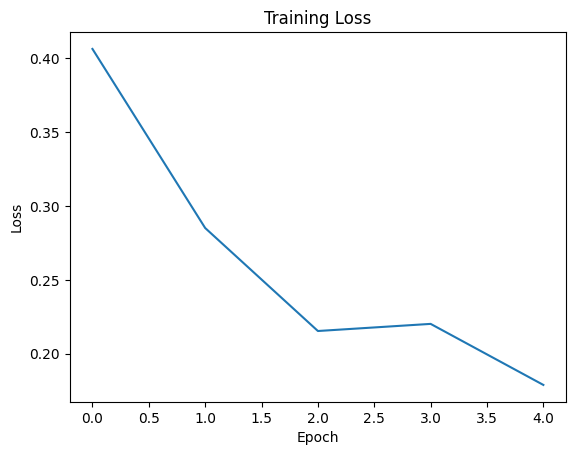

In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#evaluation

In [ ]:

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs.squeeze(dim=1)))
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

print(accuracy_score(y_true=y_true, y_pred=y_pred))
print(classification_report(y_true=y_true, y_pred=y_pred))


0.806671875
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81    159920
         1.0       0.82      0.79      0.80    160080

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



In [ ]:
model_path = 'drive/MyDrive/models/rnn-81'
torch.save(model, model_path)

In [ ]:
model = torch.load(model_path)
model.eval()

MyRNN(
  (embedding): Embedding(892350, 300, padding_idx=0)
  (rnn): RNN(300, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)